# K-Means Clustering Analysis on Retail Sales Dataset
## Prepared by: Máté Kovács (U5BKY4)

This notebook demonstrates the application of **K-Means clustering** on a synthetic retail sales dataset obtained from [Kaggle – Retail Sales Dataset](https://www.kaggle.com/datasets/mohammadtalib786/retail-sales-dataset).  
The primary objective is to explore **unsupervised learning** techniques for **customer segmentation**, while practicing data visualization with **Matplotlib**.

Through scatter plots, legends, color schemes, and subplots, the analysis highlights how clustering can reveal meaningful customer patterns based on variables such as age, quantity purchased, and total spending.

## 1) Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import seaborn as sns
import math

## 2) Load and Inspect Data

In [2]:
df = pd.read_csv("retail_sales_dataset.csv")

In [3]:
df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


In [5]:
df.describe()

,Transaction ID,Age,Quantity,Price per Unit,Total Amount
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,500.500000,41.39200,2.514000,179.890000,456.000000
std,288.819436,13.68143,1.132734,189.681356,559.997632
min,1.000000,18.00000,1.000000,25.000000,25.000000
25%,250.750000,29.00000,1.000000,30.000000,60.000000
50%,500.500000,42.00000,3.000000,50.000000,135.000000
75%,750.250000,53.00000,4.000000,300.000000,900.000000
max,1000.000000,64.00000,4.000000,500.000000,2000.000000


In [6]:
df.isna().sum()

Transaction ID      0
Date                0
Customer ID         0
Gender              0
Age                 0
Product Category    0
Quantity            0
Price per Unit      0
Total Amount        0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

## 3) Data Cleaning and Encoding

In [8]:
# Dropping non-relevant columns
df_clean = df.drop(columns=["Transaction ID", "Date", "Customer ID"])

# Encoding categorical columns
le_gender = LabelEncoder()
le_category = LabelEncoder()
df_clean["Gender"] = le_gender.fit_transform(df_clean["Gender"])
df_clean["Product Category"] = le_category.fit_transform(df_clean["Product Category"])

features = ["Age", "Quantity", "Price per Unit", "Total Amount", "Gender", "Product Category"]
X = df_clean[features]

df_clean.head()

,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,34,0,3,50,150
1,0,26,1,2,500,1000
2,1,50,2,1,30,30
3,1,37,1,1,500,500
4,1,30,0,2,50,100


## 4) Data Standardization

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Get back original values for plotting
X_original = scaler.inverse_transform(X_scaled)

scaled_means = X_scaled.mean(axis=0)
scaled_stds = X_scaled.std(axis=0)
orig_means = X_original.mean(axis=0)
orig_stds = X_original.std(axis=0)

diff_table = pd.DataFrame({
    "Feature": features,
    "Original Mean": orig_means.round(4),
    "Original Std": orig_stds.round(4),
    "Scaled Mean": scaled_means.round(4),
    "Scaled Std": scaled_stds.round(4)
})
print("=== Comparison of Original vs Scaled Features ===")
display(diff_table)

=== Comparison of Original vs Scaled Features ===


,Feature,Original Mean,Original Std,Scaled Mean,Scaled Std
0,Age,41.392,13.6746,-0.0,1.0
1,Quantity,2.514,1.1322,0.0,1.0
2,Price per Unit,179.890,189.5865,0.0,1.0
3,Total Amount,456.000,559.7176,-0.0,1.0
4,Gender,0.490,0.4999,0.0,1.0
5,Product Category,1.035,0.8048,0.0,1.0


## 5) Finding Optimal Number of Clusters

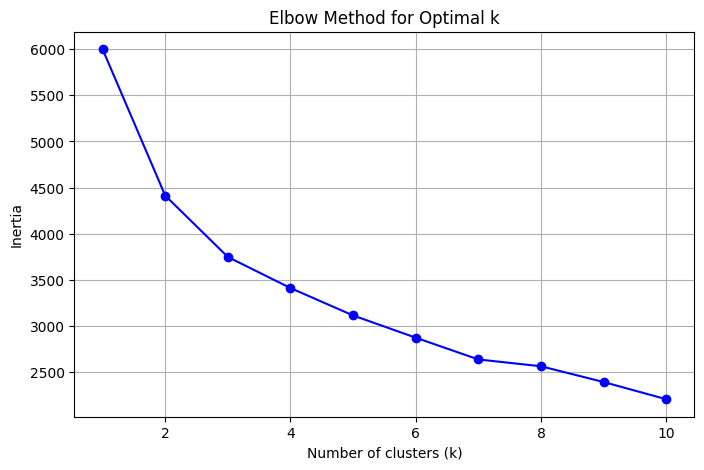

In [10]:
inertias = []
K = range(1, 11)
for k in K:
    model = KMeans(n_clusters=k, n_init="auto", random_state=55)
    model.fit(X_scaled)
    inertias.append(model.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

## 6) Define Helper Functions

In [11]:
def fit_kmeans(data, n_clusters=3):
    """Train a KMeans model and return labels and centers."""
    model = KMeans(n_clusters=n_clusters, n_init="auto", random_state=55)
    labels = model.fit_predict(data)
    centers = model.cluster_centers_
    return labels, centers


def visualize_clusters(data, feature_labels, cluster_tags, centers, base_filename="retail_clusters"):
    """Visualize clusters with distinct colors, markers, and saved figures."""
    for idx, (x_idx, y_idx) in enumerate(zip([0, 2], [1, 3], strict=True)):
        plt.figure(figsize=(10, 6))

        palette = ["purple", "teal", "gold"]
        symbols = ["D", "o", "^"]

        for i in range(len(set(cluster_tags))):
            plt.scatter(
                data[cluster_tags == i, x_idx],
                data[cluster_tags == i, y_idx],
                s=60,
                c=palette[i],
                marker=symbols[i],
                label=f"Cluster {i + 1}",
                alpha=0.8
            )

        plt.scatter(
            centers[:, x_idx],
            centers[:, y_idx],
            s=250,
            marker="*",
            c="red",
            label="Centroids",
        )

        plt.title(f"K-Means Clustering of Retail Data\n({feature_labels[x_idx]} vs {feature_labels[y_idx]})")
        plt.xlabel(feature_labels[x_idx])
        plt.ylabel(feature_labels[y_idx])
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        filename = f"{base_filename}_{idx}.png"
        plt.savefig(filename)
        print(f"Plot saved to {filename}")
        plt.show()

## 7) Apply K-Means Clustering and Visualize

=== PLOT 1: Scaled values (StandardScaler applied) ===
Plot saved to retail_clusters_0.png


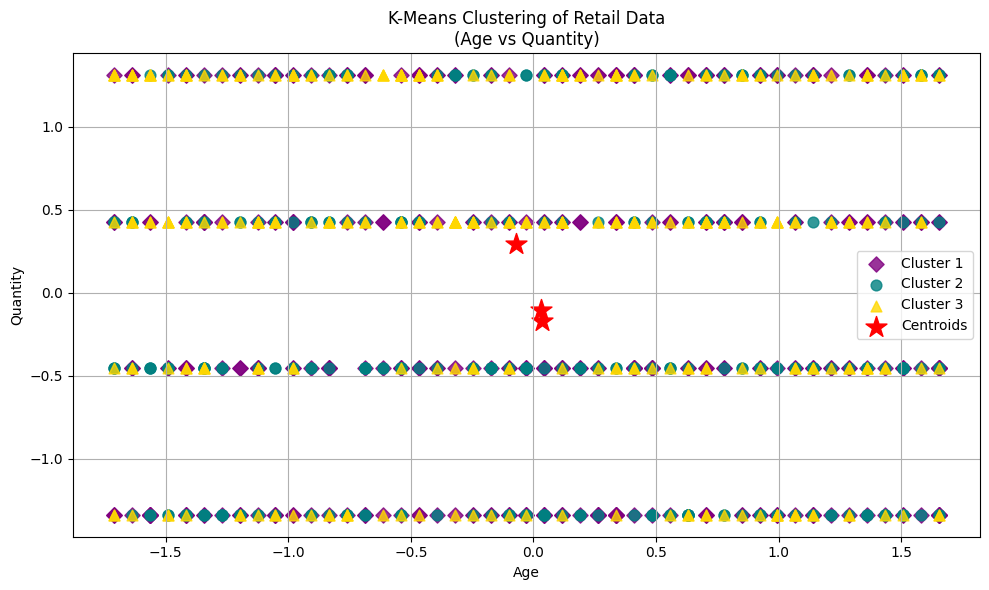

Plot saved to retail_clusters_1.png


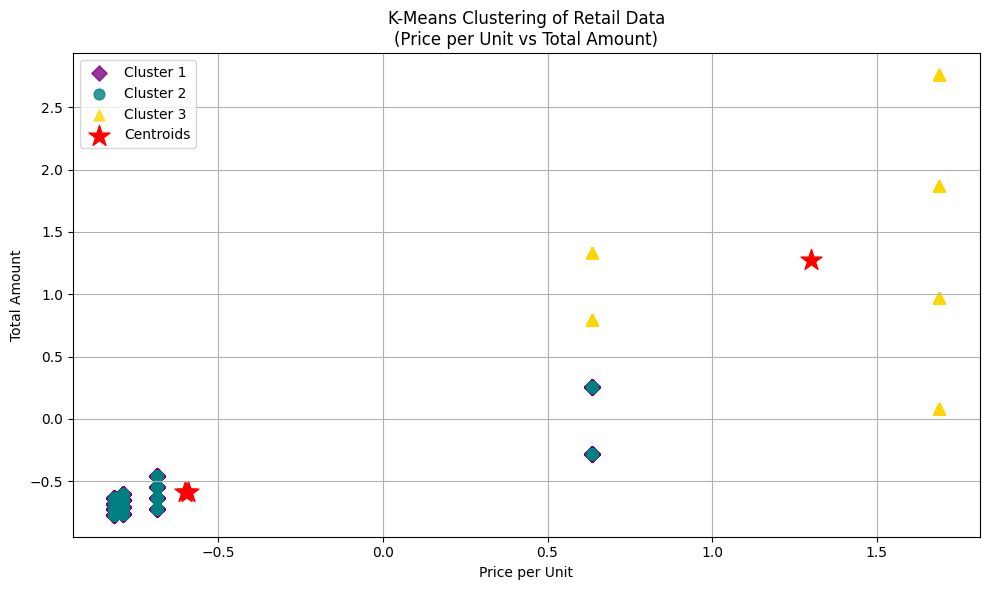

=== PLOT 2: Original values (inverse-transformed) ===
Plot saved to retail_clusters_originalscale_0.png


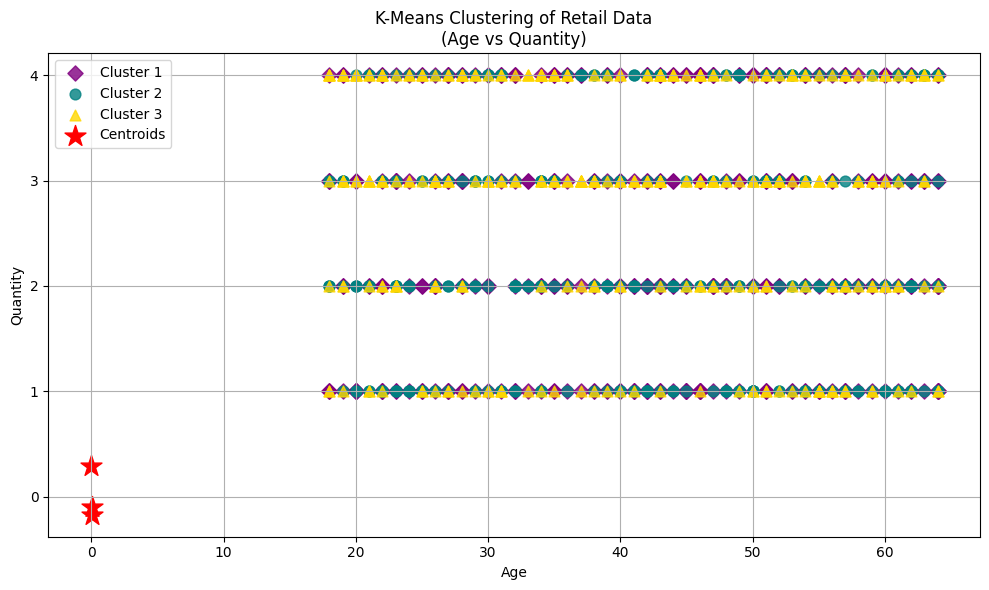

Plot saved to retail_clusters_originalscale_1.png


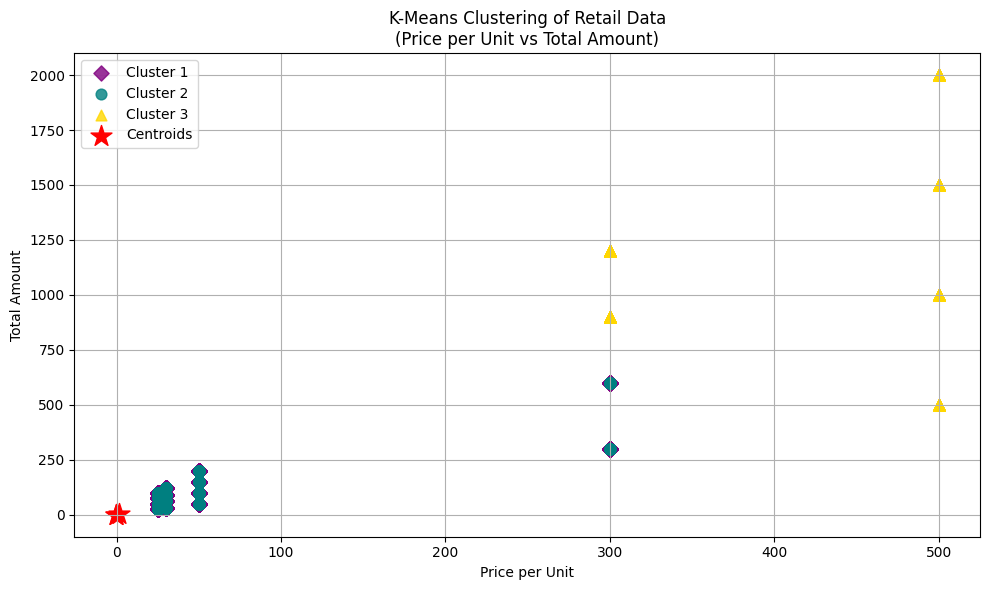

In [12]:
cluster_tags, centers = fit_kmeans(X_scaled, n_clusters=3)

print("=== PLOT 1: Scaled values (StandardScaler applied) ===")
visualize_clusters(X_scaled, features, cluster_tags, centers, base_filename="retail_clusters")

print("=== PLOT 2: Original values (inverse-transformed) ===")
visualize_clusters(X_original, features, cluster_tags, centers, base_filename="retail_clusters_originalscale")

## 8) Cluster Summary and Interpretation

In [13]:
df_clean["Cluster"] = cluster_tags
df_clean.head()

,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount,Cluster
0,1,34,0,3,50,150,1
1,0,26,1,2,500,1000,2
2,1,50,2,1,30,30,1
3,1,37,1,1,500,500,2
4,1,30,0,2,50,100,1


In [14]:
# mean values for each cluster
cluster_summary = df_clean.groupby("Cluster").mean().round(4)
print("Cluster Averages:")
display(cluster_summary)

def interpret_clusters(summary):
    interpretations = []
    for i, row in summary.iterrows():
        desc = []
        if row["Total Amount"] > summary["Total Amount"].mean():
            desc.append("high spenders")
        else:
            desc.append("budget-conscious buyers")
        if row["Age"] < summary["Age"].mean():
            desc.append("younger customers")
        else:
            desc.append("older segment")
        if row["Quantity"] > summary["Quantity"].mean():
            desc.append("buying larger quantities")
        interpretations.append(f"Cluster {i}: {'; '.join(desc)}.")
    return interpretations

for line in interpret_clusters(cluster_summary):
    print(line)

Cluster Averages:


,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
Cluster,,,,,,
0,0.0000,41.8132,1.0086,2.3994,67.3420,129.1379
1,1.0000,41.8932,1.0712,2.3205,65.7418,127.4777
2,0.4857,40.3905,1.0254,2.8476,426.3492,1168.5714


Cluster 0: budget-conscious buyers; older segment.
Cluster 1: budget-conscious buyers; older segment.
Cluster 2: high spenders; younger customers; buying larger quantities.


## 9) Visual Exploration of Feature Relationships

In [15]:
plt.style.use('seaborn-v0_8-muted')
colors = ['#4B0082', '#20B2AA', '#FFD700']

### 9.1 Line Plot

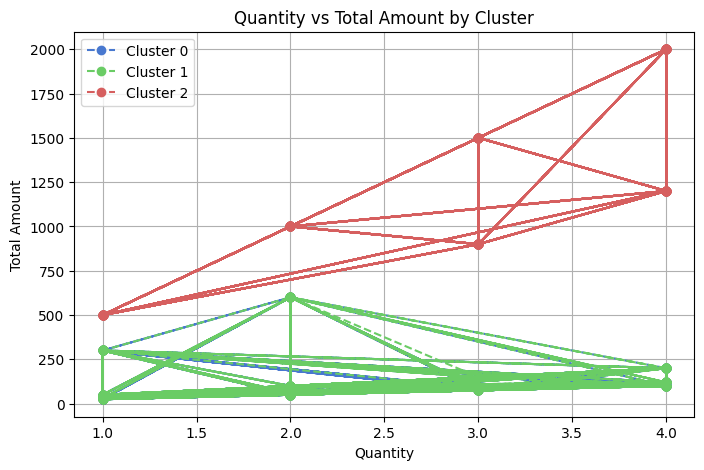

In [16]:
plt.figure(figsize=(8,5))
for c in sorted(df_clean['Cluster'].unique()):
    cluster_data = df_clean[df_clean['Cluster'] == c]
    plt.plot(cluster_data['Quantity'], cluster_data['Total Amount'], 
             linestyle='--', marker='o', label=f'Cluster {c}')
plt.title('Quantity vs Total Amount by Cluster')
plt.xlabel('Quantity')
plt.ylabel('Total Amount')
plt.legend()
plt.grid(True)
plt.show()

### 9.2 Scatter Matrix

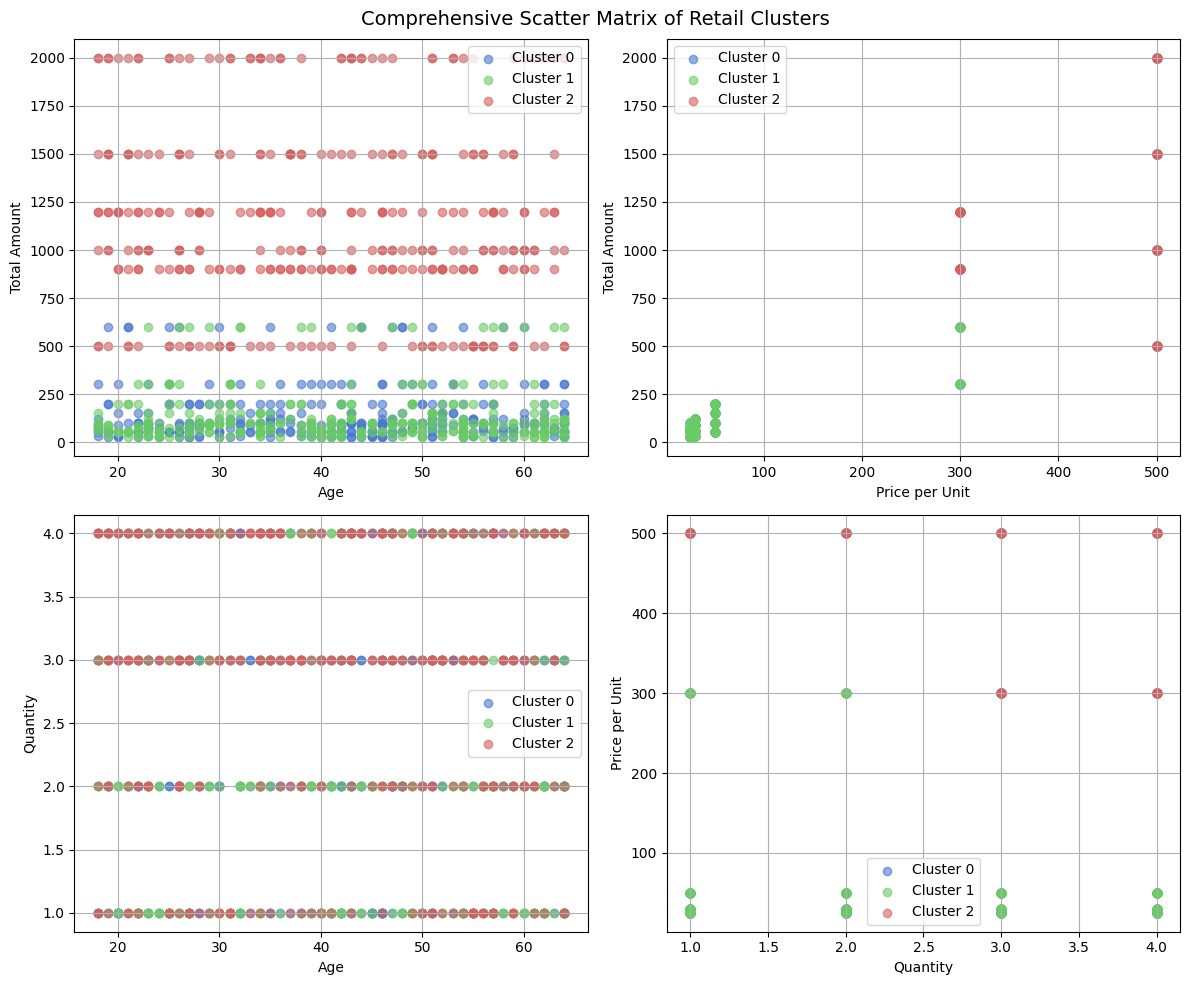

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.ravel()
pairs = [
    ('Age', 'Total Amount'),
    ('Price per Unit', 'Total Amount'),
    ('Age', 'Quantity'),
    ('Quantity', 'Price per Unit')
]
for i, (x, y) in enumerate(pairs):
    for c in range(3):
        cluster_data = df_clean[df_clean['Cluster'] == c]
        axes[i].scatter(cluster_data[x], cluster_data[y], label=f'Cluster {c}', alpha=0.6)
    axes[i].set_xlabel(x)
    axes[i].set_ylabel(y)
    axes[i].grid(True)
    axes[i].legend()
plt.suptitle("Comprehensive Scatter Matrix of Retail Clusters", fontsize=14)
plt.tight_layout()
plt.show()

### 9.3 Correlation Heatmap

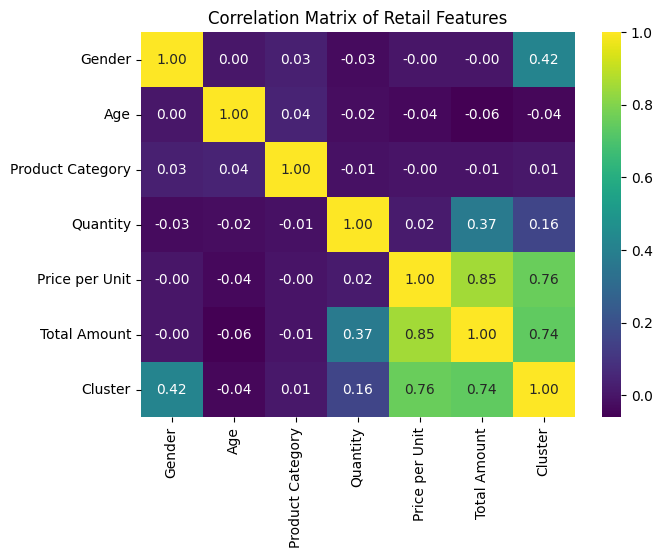

In [18]:
plt.figure(figsize=(7,5))
sns.heatmap(df_clean.corr(), annot=True, cmap="viridis", fmt=".2f")
plt.title("Correlation Matrix of Retail Features")
plt.show()

### 9.4 Bar Chart

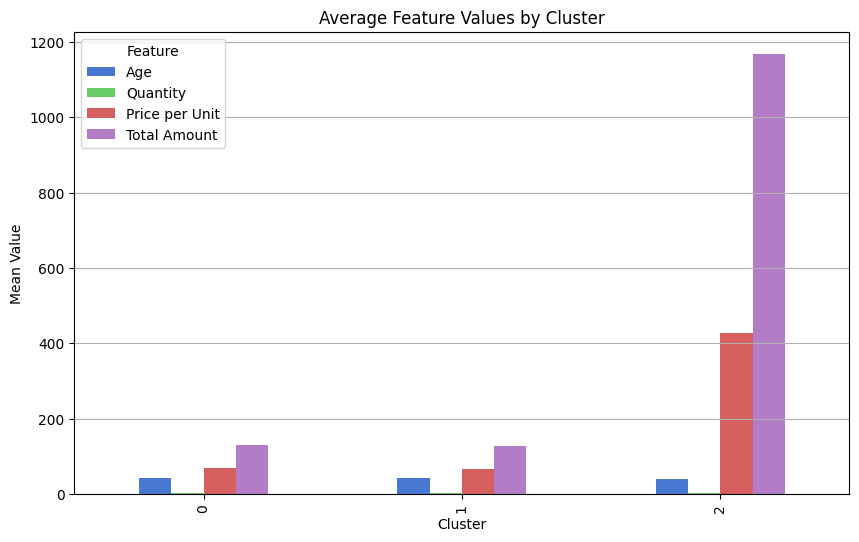

In [19]:
cluster_means = df_clean.groupby('Cluster')[['Age', 'Quantity', 'Price per Unit', 'Total Amount']].mean()
cluster_means.plot(kind='bar', figsize=(10,6))
plt.title('Average Feature Values by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Value')
plt.legend(title='Feature')
plt.grid(axis='y')
plt.show()

### 9.5 Pairplot

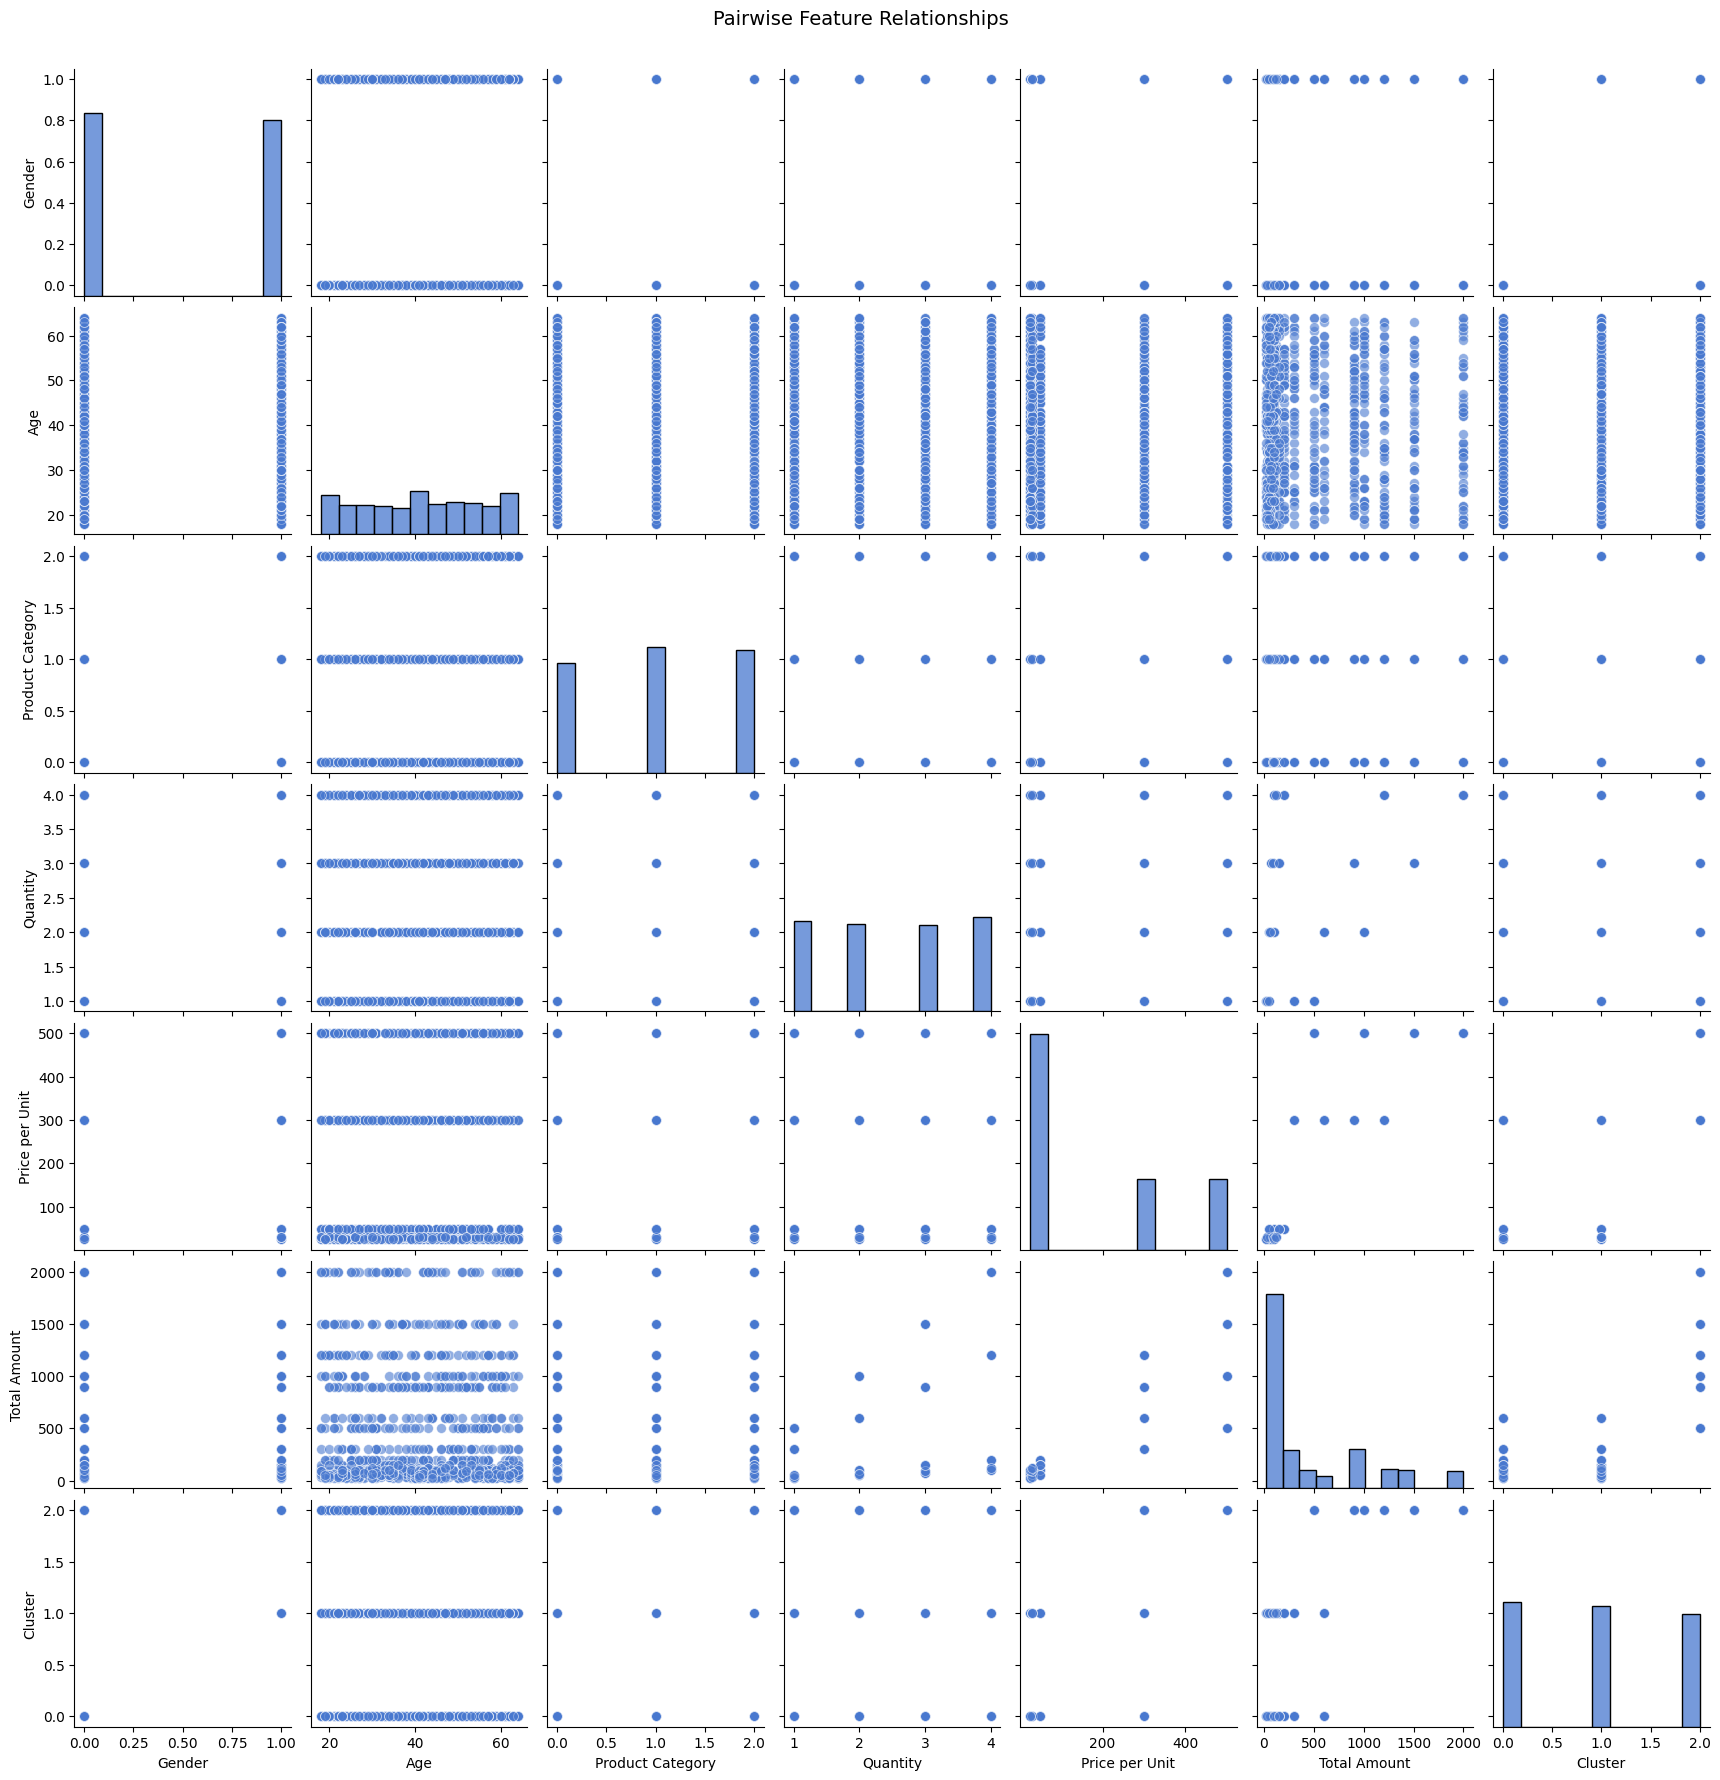

In [20]:
sns.pairplot(df_clean, diag_kind="hist", plot_kws={'alpha':0.6, 's':50})
plt.suptitle("Pairwise Feature Relationships", y=1.02, fontsize=14)
plt.show()

### 9.6 Distribution Plots

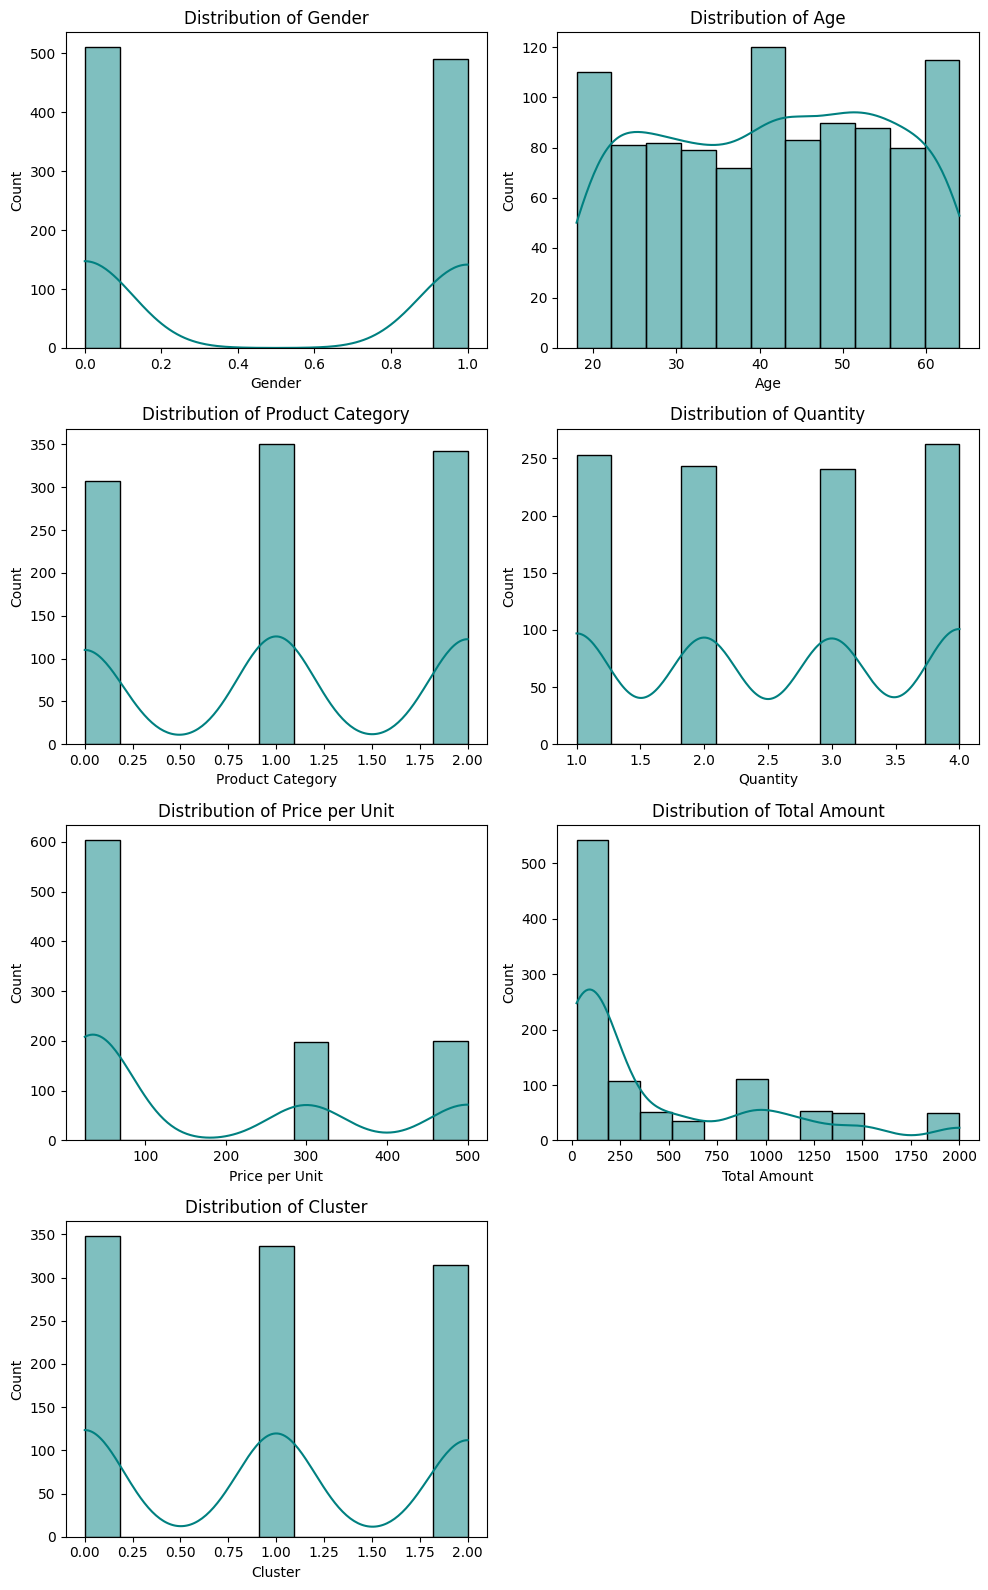

In [21]:
n_cols = len(df_clean.columns)
n_rows = math.ceil(n_cols / 2)

fig, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(df_clean.columns):
    sns.histplot(df_clean[col], kde=True, color='teal', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()